In [830]:
import os
import numpy as np
import scipy as sp
import scipy.io
from scipy.linalg import expm
import pandas as pandas
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from functools import partial
from scipy.optimize import minimize, differential_evolution, basinhopping
from Nexis_functions import heatmap, total_tau_plot, normalize_by_l2_norm, mse_matrix
from Nexis_model_forward import run_Nexis
import seaborn as sns
from scipy.stats import pearsonr

## Preparing Inputs

In [857]:
# Prepare connectivity matrix

# Load connectivity matrix
connectivity_df = pandas.read_csv('Connectivity matrix.csv')

# List of striatal regions to exclude from further analysis due to errors in tau-PET imaging (CAN EDIT THIS)
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']

# Find indices (in the region order of the connectivity matrix) for regions to exclude 
excluded_indices = [connectivity_df.columns.get_loc(region) for region in regions_to_exclude]

# Define total number of subcortical regions and cortical regions per hemisphere
total_sub = 9 - len(regions_to_exclude)/2
total_cor = 34

# Delete striatal regions 
connectivity_df = connectivity_df.drop(index = excluded_indices)
connectivity_df = connectivity_df.drop(columns=regions_to_exclude)

# Convert connectivity matrix to a nROI x nROI array
connectivity_matrix = connectivity_df.values

# Normalize connectivity matrix (divide by max because min is already 0 in diagonal entries)
max = np.max(connectivity_matrix)
connectivity_matrix = connectivity_matrix / max

Top seed regions: ['ctx-lh-inferiorparietal' 'ctx-rh-middletemporal' 'ctx-lh-middletemporal'
 'ctx-lh-fusiform' 'ctx-rh-inferiorparietal']


Text(0.5, 1.0, 'Initial vector')

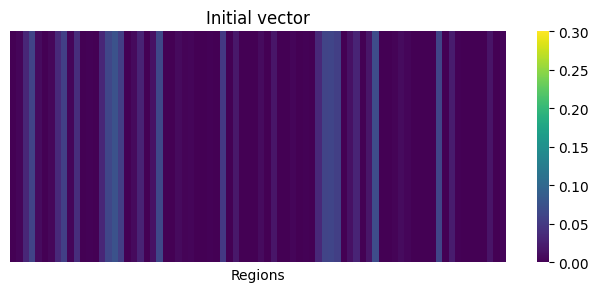

In [906]:
# Define the number of regions  
nROI = 86 - len(regions_to_exclude)

# Initial vector

# SET INITIAL VECTOR METHOD ('baseline' or 'binary')
init_vec_method = 'baseline' 

# Conversion of ADNI region order to match connectivity matrix
new_order_ADNI = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]

# Order of regions (left subcortex, right subcortex, left cortex, right cortex)
regions = ['Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala','Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula', 'ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus',	'ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']

# Upload EBM output
EBM_data = pandas.read_csv('EBM time series/EBM time series - version 9 final run.csv')

# OPTION 1: Use baseline data from EBM tau time series
if init_vec_method == 'baseline':

    # Housekeeping
    init_con = EBM_data.drop('Unnamed: 0',axis=1)

    # Reorder regions to match region order of connectivity matrix
    init_con_reordered = init_con.iloc[:, new_order_ADNI]

    # Delete striatal regions 
    columns_to_delete = init_con_reordered.columns[excluded_indices]
    init_con_excluded = init_con_reordered.drop(columns_to_delete, axis = 1)

    # Take the first row (time point 0) as initial vector
    # EBM BASELINE
    #init_vec = init_con_excluded.iloc[0].values 

    # COHORT OPTIMIZED SEED 
    # seed op 1
    #init_vec = np.array([0.0, 0.011304112457275424, 0.036058850844042686, 0.04814493101848872, 0.03230055748872313, 0.0, 0.009011398710009557, 0.03746897270754817, 0.05002887850369013, 0.028366488427254845, 0.021360791318467822, 0.0, 0.0009735987167050333, 0.0, 0.033692676004938873, 0.05145236137946829, 0.05700949196986686, 0.06028666083157203, 0.0003310353530337368, 0.012592874296736067, 0.02937113870135921, 0.0, 0.014975782654133274, 0.05729502678750474, 0.0, 0.0, 0.010459925073071833, 0.009092773751355036, 0.010480080044311979, 0.0, 0.0, 0.0045310461802588065, 0.0, 0.046037503750370155, 0.0, 0.02046641914154815, 0.007356056084442503, 0.0, 0.006472404067546021, 0.012275339559534807, 0.0, 0.021682408662505783, 0.0, 0.004501167515582106, 0.001242488895244541, 0.0, 0.0007301484573432235, 0.0011740795705745485, 0.034022296998489986, 0.05729093929199165, 0.05351235759122386, 0.05336502814427264, 0.0, 0.02098132753063509, 0.03095663158359688, 0.0, 0.019071103565064033, 0.060213254988822074, 0.0, 0.0, 0.0036560570961931315, 0.015323260396209883, 0.010714688370568111, 0.0, 0.0, 0.0004020760093213823, 0.0, 0.05107295625699623, 0.0, 0.024524621135153815, 0.007146471405409794, 0.0, 0.0, 0.0, 0.0, 0.014286413378088503, 0.0, 0.00483365223568623])
    # seed op 2
    init_vec = np.array([0.0, 0.00464220779146618, 0.031659384414973235, 0.060385443970198065, 0.00885781200894669, 0.0, 0.005827249972898467, 0.0339956071285847, 0.056692643842895574, 0.004382957455027453, 0.0385801014750831, 0.0, 0.0016101236234474729, 0.0, 0.032283916591279424, 0.06253830831479082, 0.07520735969834622, 0.054508084055119976, 0.0, 0.0070804848878949535, 0.02895961292648051, 0.0, 0.012909412840881204, 0.06353391566970382, 0.0, 0.0, 0.007324127568765414, 0.0028951767846783086, 0.004263593757685369, 0.0, 0.0, 0.0016198033903952603, 0.0, 0.049929478470820673, 0.0, 0.019401441650351167, 0.0008350104662978752, 0.0, 0.0, 0.00877069241104221, 0.0, 0.01752556213015195, 0.0, 0.0, 0.004641481115764106, 0.0, 0.0016377274618478556, 0.0, 0.03294662487056662, 0.06091814802129116, 0.061623996754677626, 0.05519578063796581, 0.0, 0.013116273432301734, 0.030062735692711867, 0.0, 0.016536052039014097, 0.06881140503442316, 0.0, 0.0, 0.0031454482149944427, 0.008684170232813182, 0.0043126066064372035, 0.0, 0.0, 0.0, 0.0, 0.06049991642080132, 0.0, 0.02235490746266193, 0.0018409481172619122, 0.0, 0.0, 0.0, 0.0, 0.01618616951895882, 0.0, 0.003975620327354512])
    
    use_baseline_ = 1

#OPTION 2: Binary vector indicating seeding location 
if init_vec_method == 'binary':

    seeding_locations = ['ctx-lh-entorhinal', 'ctx-rh-entorhinal'] # MANUALLY EDIT SEEDING LOCATION HERE
    seeding_indices = [regions.index(item) for item in seeding_locations if item in seeding_locations]

    # Create a 1D array of zeros with length nROI
    array_length = nROI
    init_vec = np.zeros(array_length)

    # Set entries for seeding locations to 1 (both left and right hemisphere)
    init_vec[seeding_indices[0]] = 1 
    init_vec[seeding_indices[1]] = 1

    # Set use_baseline NEXIS input to 0 to indicate use of binary initial vector 
    use_baseline_ = 0 

# Print highest tau seed regions
top_seed_values = sorted(init_vec, reverse=True)[:5]
top_indices = sorted(range(len(init_vec)), key=lambda i: init_vec[i], reverse=True)[:5]
regions_array = np.array(regions)
top_seeds = regions_array[top_indices]
print('Top seed regions: ' + str(top_seeds))

# Plot initial vector
plt.figure(figsize=(8, 3)) 
init_vec_reshaped = init_vec.reshape((78,1))
sns.heatmap(init_vec_reshaped.T, cmap='viridis', xticklabels=False, yticklabels=False, vmax = 0.3)
plt.xlabel('Regions')
plt.title('Initial vector')

In [897]:
# Load DK regional volumes 
regional_volumes = pandas.read_csv('DK_ROI_volumes.csv')

# Convert to an 1 x nROI array 
regional_volumes = regional_volumes.values

# Reorder to match that of connectivity matrix
new_order = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67]
regional_volumes_reordered = regional_volumes[new_order, :]

# Delete striatal regions
regional_volumes_excluded = np.delete(regional_volumes_reordered,excluded_indices)

In [907]:
# Run on either individual subjects (1) or whole cohort (0) (SET HERE)
individual = 1

In [908]:
# Define inputs to NEXIS

C_ = connectivity_matrix  # Connectivity matrix (nROI x nROI)
U_ = np.zeros((nROI, 1))  # Don't care about cell types (nROI x nTypes), set to nROI x 1 array of random numbers or 0
init_vec_ = init_vec # Initial tau vector (nROI x 1)
if individual == 1:
    t_vec_ = np.linspace(0, 18, 19)
else:
    t_vec_ = np.linspace(0, 10, 100)  # Time vector (include 100 time points) (1 x nt)
w_dir_ = 0  # Since I don't care about directionality, set to 0 which overwrites s as 0.5
volcorrect_ = 1  # Binary flag set to 0 if not correcting for volume, set to 1 if correcting for volume and add regional volume data to regional_volumes
region_volumes_ = regional_volumes_excluded  # Regional volumes for normalization (nROI x 1)
degreecorrect_ = 0 # Binary flag indicating whether to normalize by degree (for Ashish, normally set this to 0)
logistic_term_ = 1 # Binary flag set to 1 to run with logistic term and 0 to run without

## Load EBM Data

In [909]:
if individual == 1:
    patient_data = pandas.read_csv('EBM stage + tau/Stage + tau - version 9 final run.csv')

    RID = 6100	#EDIT PATIENT RID MANUALLY HERE
    patient = patient_data[patient_data['RID'] == RID] 

    # Define number of time points 
    num_time_points = patient.shape[0]

    # Define list with stage assingments for each time point
    stages = patient['ml_stage'].tolist()
    stages = [int(x) for x in stages]
    # LATER: DEFINE IN TERMS OF TIME WHERE TIME vs. STAGE RELAITONSHIP IS SIGNMOIDAL

    # Define patient tau data
    patient_tau = patient.iloc[:,3:]

    # Reorder regions to match region order of connectivity matrix
    new_order_ADNI = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]
    patient_tau = patient_tau.iloc[:, new_order_ADNI]

    # Delete striatal regions 
    patient_tau = patient_tau.drop(regions_to_exclude, axis = 1)

    # Convert to array and transpose so dim = nROI x # of stages
    patient_tau = patient_tau.to_numpy()
    patient_tau = patient_tau.T

else:

    # Housekeeping
    EBM_data = EBM_data.drop('Unnamed: 0',axis=1)

    # Convert to an nROI x 100 array and transpose
    EBM_data_array = EBM_data.values
    EBM_data_transposed = EBM_data_array.T

    # Reorder regions to match region order in NDM output
    new_order = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]
    EBM_data_reordered = EBM_data_transposed[new_order, :]

    # Delete striatal regions 
    EBM_data_excluded = np.delete(EBM_data_reordered, excluded_indices,axis = 0)

    # Take average of regions at t=0 and use normalize entire interpolation 
    #ebm_seed_mean = EBM_data_excluded[:,0].mean()
    #EBM_data_excluded = EBM_data_excluded / 1.5

    # Normalize by L2 norm
    #normalized_EBM_data_excluded = normalize_by_l2_norm(EBM_data_excluded)

## Parameter Optimization

In [910]:
# Define cost function 
def Nexis_error(params, patient_tau):
    
    param1, param2, param3, param4, param5, param6, param7 = params 
    # param1 = alpha, param2 = beta, param3 = gamma, param4 = s, param5 = b, param6 = p, param7 =k
    
   # Initialize run_Nexis object 
    nexis_optimizing = run_Nexis(C_=C_, U_=U_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                        region_volumes_=region_volumes_, logistic_term_ = logistic_term_)

    # Parameters for simulate_nexis method
    parameters = [param1, param2, param3, param4, param5, param6, param7]  # [alpha, beta, gamma, s, b, p , k] 

    # Call the simulate_nexis method with the parameters
    Y = nexis_optimizing.simulate_nexis(parameters)

    if individual == 1:
        # For optimization, only take stages from Y that correspond to patient's stages 
        Y_edited = Y[:, stages] 

        # Check if Y_edited is constant
        if np.all(Y_edited == Y_edited[0]):
            Y_edited[0] = Y_edited[0] + 0.00001 # Add small constant 
        corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
        error = mse_matrix(patient_tau, Y_edited) + 0.5 * (1- corr_coeff) 
    
    else:
        # Fit to EBM interpolation
        corr_coeff, p_value = pearsonr(EBM_data_excluded.flatten(), Y.flatten())
        error = mse_matrix(EBM_data_excluded, Y) + 0.5 * (1- corr_coeff)

        # Fit to 
    
    return error

In [911]:
custom_Nexis_error = partial(Nexis_error, patient_tau=patient_tau)

# Initial guesses for parameters (alpha, beta, gamma, s, b, p, k) # ADJUST THESE
init_guess = np.array([0.2, 1.01, 1, 0.5, 0, 0.0, 50])

# Bounds for each parameter [(min alpha, max alpha), (min beta, max beta), (min gamma, max gamma), etc. # ADJUST THESE
bounds = [(0, 3),(0, 4),(1,1),(0.5,0.5),(0,0),(0,0),(50,50)]

# Perform the optimization
result = minimize(custom_Nexis_error, init_guess, bounds=bounds, method='Powell', # Methods: Powell OR L-BFGS-B
                  options={'xtol': 1e-4, 'ftol': 1e-4,'maxiter': 1000})

if result.success:
    optimized_params = result.x
    optimized_params = optimized_params.tolist()
    print(f"Optimization successful. Optimized parameters (alpha, beta, gamma, s, b, p, k): {optimized_params}")
    print(f"Final error (value of objective function): {result.fun}")
else:
    print("Optimization failed.", result.message)
    print(f"Final error (value of objective function): {result.fun}")

Optimization successful. Optimized parameters (alpha, beta, gamma, s, b, p, k): [0.23045491990075584, 0.07427119709552188, 1.0, 0.5, 0.0, 0.0, 50.0]
Final error (value of objective function): 3.1441467704557216


ValueError: x and y must have same first dimension, but have shapes (3,) and (1,)

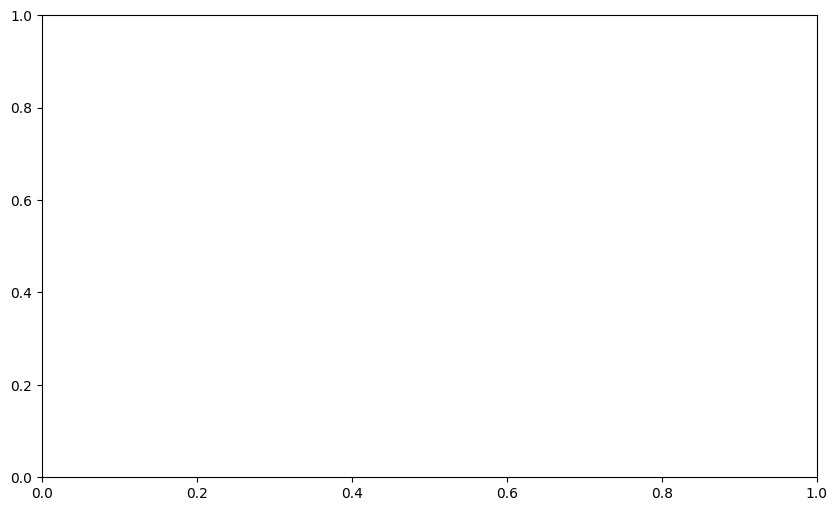

In [863]:
# TEMP: Plot objective function error across iterations

# Final run
error_iter = np.array([0.06056400588283755, 0.06878384725259754])
R_iter = [0.8941663636416688, 0.900577]
MSE_iter = [0.00764718, 0.01907242]
iterations = np.array([1, 2, 3])

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each line
plt.plot(iterations, error_iter, marker='o', linestyle='-', color='b', label='Error')
plt.plot(iterations, MSE_iter, marker='s', linestyle='--', color='r', label='MSE')
plt.plot(iterations, R_iter, marker='^', linestyle='-.', color='g', label='R')

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Values')
plt.title('Error, MSE, and R Values Across Seed/Param-Op Iterations')

# Add a legend
plt.legend()

# Add a grid for better readability
plt.grid(True, linestyle=':', alpha=0.7)

# Display the plot
plt.show()

In [869]:
# TESTING (looping through different initial guesses and trying different optimization algorthyms)

from scipy.optimize import minimize, differential_evolution, basinhopping

def safe_objective(params):
    try:
        print("Input parameters:", params)
        result = custom_Nexis_error(params)  # Your original objective function
        print("Result:", result)
        if np.isinf(result) or np.isnan(result):
            print("Warning: Infinite or NaN result")
            return 1e10  # A large, finite number
        return result
    except Exception as e:
        print(f"Error in objective function: {e}")
        return 1e10  # A large, finite number

# Check input data
print("Any NaN in patient_tau:", np.isnan(patient_tau).any())
print("Any inf in patient_tau:", np.isinf(patient_tau).any())

# Parameter bounds
bounds = [(0, 2), (0, 3), (1, 1), (0.5, 0.5), (0, 0), (0, 0), (50, 50)]

# Multiple starting points
initial_guesses = [
    [0.1, 0.1, 1.0, 0.5, 0, 0.0, 50],
    [0.5, 0.5, 1.0, 0.5, 0, 0.0, 50],
    [1, 1, 1.0, 0.5, 0, 0.0, 50]
]
# Global optimization using Differential Evolution
de_result = differential_evolution(safe_objective, bounds, strategy='best1bin', 
                                   popsize=15, tol=0.01, mutation=(0.5, 1), 
                                   recombination=0.7, seed=None, maxiter=1000, 
                                   polish=True)

# Global optimization using Basin-hopping
bh_result = basinhopping(safe_objective, initial_guesses[0], niter=100, T=1.0, 
                         stepsize=0.5, minimizer_kwargs={'method': 'L-BFGS-B', 'bounds': bounds})

# Compare results
results = [de_result, bh_result]
best_overall = min(results, key=lambda x: x.fun)

print(f"Best parameters: {best_overall.x}")
print(f"Best objective value: {best_overall.fun}")


Any NaN in patient_tau: False
Any inf in patient_tau: False
Input parameters: [ 1.04823763  1.13703504  1.          0.5         0.          0.
 50.        ]
Result: 456.33782763920584
Input parameters: [ 1.61426599  2.32601677  1.          0.5         0.          0.
 50.        ]
Result: 1139.9769271524347
Input parameters: [ 0.84095836  1.63179994  1.          0.5         0.          0.
 50.        ]
Result: 133.14616708049678
Input parameters: [ 0.16878473  2.48617524  1.          0.5         0.          0.
 50.        ]
Result: 0.2413137957889131
Input parameters: [ 0.28983658  1.39476517  1.          0.5         0.          0.
 50.        ]
Result: 0.2104360568979037
Input parameters: [ 0.36503193  0.22457504  1.          0.5         0.          0.
 50.        ]
Result: 0.16437500947856423
Input parameters: [ 1.18505784  2.87198745  1.          0.5         0.          0.
 50.        ]
Result: 666.6361127527654
Input parameters: [ 1.30819652  1.51729482  1.          0.5         0.  

## Running Nexis

Pearsons R: 0.13466278755532057
Mean squared error: 2.711478164233382
Final error: 3.1441467704557216


Text(0, 0.5, 'Regions')

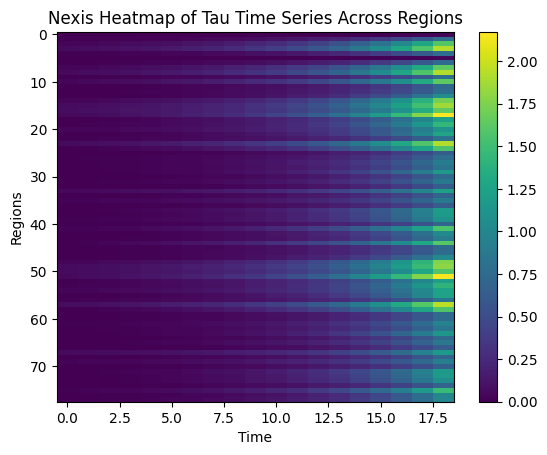

In [912]:
# Initialize run_Nexis class 
nexis_model = run_Nexis(C_=C_, U_=U_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                        region_volumes_=region_volumes_, logistic_term_=logistic_term_)

# Parameters for simulate_nexis method
parameters = optimized_params  # [alpha, beta, gamma, s, b, p, k] 
#parameters = [] # CAN MANUALLY SET PARAMETERS HERE

# Call the simulate_nexis method with the parameters
Y = nexis_model.simulate_nexis(parameters)

if individual == 1:
    Y_edited = Y[:, stages] # Take stages from Y that correspond to patient's stages 
    corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
    mse = mse_matrix(patient_tau, Y_edited)
    final_error = mse + 0.5 * (1- corr_coeff)
else:
    normalized_Y = normalize_by_l2_norm(Y) # Normalize by L2 norm
    corr_coeff, p_value = pearsonr(EBM_data_excluded.flatten(), Y.flatten())
    mse = mse_matrix(EBM_data_excluded, Y)
    final_error = mse + 0.5 * (1- corr_coeff)
    
print('Pearsons R: ' + str(corr_coeff))
print('Mean squared error: ' + str(mse))
print('Final error: ' + str(final_error))

# Plot heatmap of Y
plt.imshow(Y, cmap='viridis', interpolation='none', aspect='auto')
plt.colorbar()  # Add a color bar to map colors to values
plt.title('Nexis Heatmap of Tau Time Series Across Regions')
plt.xlabel('Time')  
plt.ylabel('Regions')
#ax = plt.gca()
#ax.set_xticklabels([])
#ax.set_yticklabels([])

## Check Results

ValueError: x and y must have same first dimension, but have shapes (100,) and (19,)

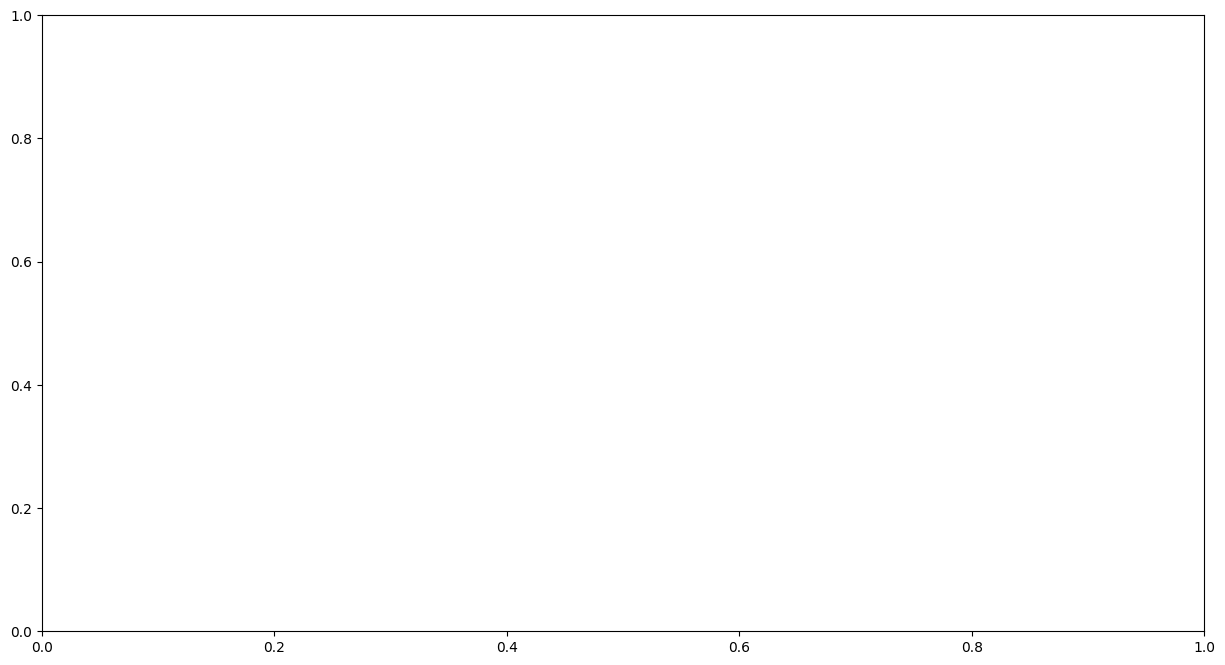

In [913]:
# Plot regions of Y against those region in EBM regional interpolations

Y_for_figure = pandas.DataFrame(Y)
Y_for_figure = Y_for_figure.T
Y_for_figure.columns = regions
Y_for_figure = Y_for_figure[['ctx-lh-inferiortemporal','ctx-lh-entorhinal','Left-Hippocampus']]
Y_for_figure = Y_for_figure.rename(columns={'ctx-lh-inferiortemporal': 'inferiortemporal_Y', 'ctx-lh-entorhinal': 'entorhinal_Y', 'Left-Hippocampus': 'Hippocampus_Y'})

EBM_for_figure = pandas.DataFrame(EBM_data_excluded)
EBM_for_figure = EBM_for_figure.T
EBM_for_figure.columns = regions
EBM_for_figure = EBM_for_figure[['ctx-lh-inferiortemporal','ctx-lh-entorhinal','Left-Hippocampus']]
EBM_for_figure = EBM_for_figure.rename(columns={'ctx-lh-inferiortemporal': 'inferiortemporal_EBM', 'ctx-lh-entorhinal': 'entorhinal_EBM', 'Left-Hippocampus': 'Hippocampus_EBM'})

for_figure = pandas.merge(EBM_for_figure,Y_for_figure,left_index=True, right_index=True)

plt.figure(figsize=(15, 8))
colors = ['#FE0101', '#FFD700', '#00008B', '#FA8072', '#FFFF66', '#87CEFA']
xnew = np.linspace(0, 16, 100) 

for idx, (col, color) in enumerate(zip(for_figure.columns, colors)):
    col_data = for_figure[col]
    plt.plot(xnew, col_data, '-', color=color, label=col, linewidth=2.5)

# Remove tick labels but keep ticks
#plt.gca().set_xticklabels([])
#plt.gca().set_yticklabels([])

plt.legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=1)

# Keep axis labels
plt.title('Nexis fit to EBM interpolation across regions')
plt.xlabel('Stages')
plt.ylabel('Tau density')

# Show the plot
plt.show()


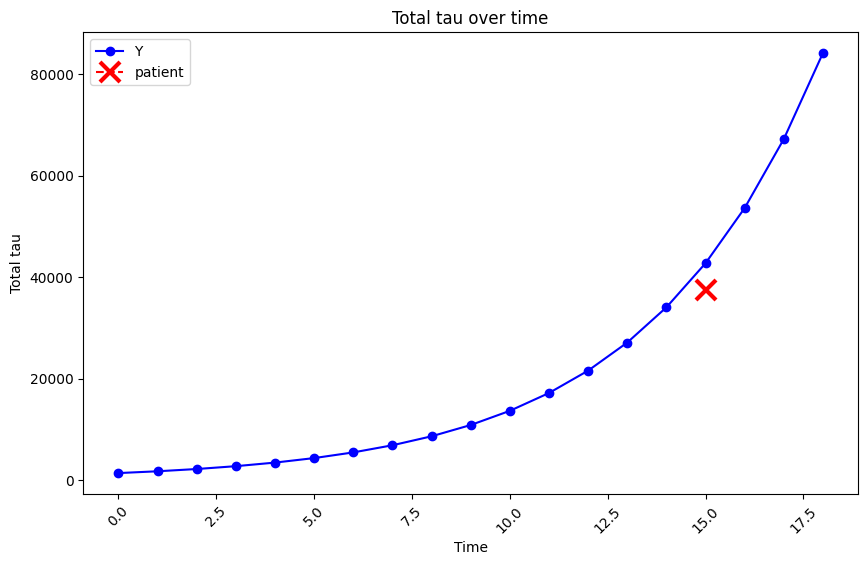

In [914]:
regional_volumes_array = np.array(regional_volumes_excluded)
regional_volumes_array = regional_volumes_array.reshape((78,1))
tau_mass_Y = regional_volumes_array * Y
total_tau_Y = np.sum(tau_mass_Y, axis=0)

if individual == 1:
    # Volume correction
    patient_tau = patient_tau.reshape(78,1)
    tau_mass_patient = regional_volumes_array * patient_tau
    total_tau_patient = np.sum(tau_mass_patient, axis=0)

    time_points_Y = np.linspace(0, 18, 19)

    plt.figure(figsize=(10, 6))

    # Plot total_tau_Y
    plt.plot(time_points_Y, total_tau_Y, marker='o', linestyle='-', color='b', label= 'Y')  

    # Plot total_tau_patient on the same graph
    plt.plot(stages, total_tau_patient, marker='x', linestyle='--', color='r', label= 'patient', markersize=15, markeredgewidth=3)

    plt.title('Total tau over time') 
    plt.xlabel('Time')  # Label the x-axis
    plt.ylabel('Total tau')  # Label the y-axis
    plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
    plt.legend()  # Add a legend to distinguish the two lines

    # Show the plot
    plt.show
    
else:
    # Plot total tau over time to compare the scales of EBM and Y
    EBM_mass = regional_volumes_array * EBM_data_excluded
    EBM_total_tau = np.sum(EBM_mass, axis=0)

    time_points = np.linspace(0, 99, 100)

    plt.figure(figsize=(10, 6))

    # Plot total_tau_Y
    plt.plot(time_points, total_tau_Y, marker='o', linestyle='-', color='b', label= 'Y')  

    # Plot EBM interpolation on the same graph
    plt.plot(time_points, EBM_total_tau, marker='x', linestyle='--', color='r', label= 'EBM')

    plt.title('Total tau over time') 
    plt.xlabel('Time')  # Label the x-axis
    plt.ylabel('Total tau')  # Label the y-axis
    plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
    plt.legend()  # Add a legend to distinguish the two lines

    # Show the plot
    plt.show

## Loop Through All Subjects 
If running on individuals

In [915]:
# Avoid repeating any RIDS
unique_rids = patient_data['RID'].unique()

#Create a data frame for all patients seeding patterns
column_names = ['RID', 'MSE', 'R', 'alpha', 'beta', 'gamma', 's', 'b', 'p', 'k']
parameters_all = pandas.DataFrame(columns=column_names)

for rid in unique_rids:

    patient = patient_data[patient_data['RID'] == rid] 

    # Define number of time points 
    num_time_points = patient.shape[0]

    # Define list with stage assingments for each time point
    stages = patient['ml_stage'].tolist()
    stages = [int(x) for x in stages]

    # Define patient tau data
    patient_tau = patient.iloc[:,3:]

    # Reorder regions to match region order of connectivity matrix
    patient_tau = patient_tau.iloc[:, new_order_ADNI]

    # Delete striatal regions 
    patient_tau = patient_tau.drop(regions_to_exclude, axis = 1)

    # Convert to array and transpose so dim = nROI x # of stages
    patient_tau = patient_tau.to_numpy()
    patient_tau = patient_tau.T

    # Check for NaN or inf values in patient_tau
    if np.isnan(patient_tau).any() or np.isinf(patient_tau).any():
        print(f"Skipping RID {rid} due to NaN or inf values in patient_tau")
        continue

    # Perform the optimization
    custom_Nexis_error = partial(Nexis_error, patient_tau=patient_tau)

    result = minimize(custom_Nexis_error, init_guess, bounds=bounds, method='Powell', 
                    options={'xtol': 1e-3, 'ftol': 1e-3, 'maxiter': 1000})
    
    if result.success:
        optimized_params = result.x
        optimized_params = optimized_params.tolist()

        # Run Nexis    
        Y = nexis_model.simulate_nexis(optimized_params) 
        Y_edited = Y[:, stages]

        # Check for NaN or inf values in Y_edited
        if np.isnan(Y_edited).any() or np.isinf(Y_edited).any():
            print(f"Skipping RID {rid} due to NaN or inf values in Y_edited")
            continue
        
        # Calculate MSE and R
        mse = mse_matrix(patient_tau, Y_edited)
        corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
        
        # Create data frame for the subject
        parameters = pandas.DataFrame([[rid] + [mse] + [corr_coeff] + optimized_params], columns=column_names)

        # Concatenate the original DataFrame with the new DataFrame
        parameters_all = pandas.concat([parameters_all, parameters], ignore_index=True)

parameters_all

/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_9418/1139769197.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  parameters_all = pandas.concat([parameters_all, parameters], ignore_index=True)


,RID,MSE,R,alpha,beta,gamma,s,b,p,k
0,21,0.023729,0.222271,2.999493,3.999641,1.0,0.5,0.0,0.0,50.0
1,31,0.008136,0.248263,2.999493,3.999641,1.0,0.5,0.0,0.0,50.0
2,56,0.027044,0.248721,2.999493,3.999641,1.0,0.5,0.0,0.0,50.0
3,59,0.052427,0.248425,1.115735,0.422543,1.0,0.5,0.0,0.0,50.0
4,69,0.053468,0.211269,1.113591,0.389515,1.0,0.5,0.0,0.0,50.0
...,...,...,...,...,...,...,...,...,...,...
645,6704,0.014697,0.157207,1.663835,0.742180,1.0,0.5,0.0,0.0,50.0
646,6705,0.618258,0.145033,0.267912,0.121897,1.0,0.5,0.0,0.0,50.0
647,6713,0.023778,0.245246,2.999493,3.999641,1.0,0.5,0.0,0.0,50.0
648,6721,0.054377,0.201534,1.078856,0.417419,1.0,0.5,0.0,0.0,50.0


In [1]:
# Add diagnosis and ml_stage information to data frame
parameters_all.insert(1, 'Diagnosis', patient_data['Diagnosis'])
parameters_all.insert(2, 'ml_stage', patient_data['ml_stage'])

# Save to a csv 
parameters_all.to_csv('seed vs. param op/Optimized param - version 9 final run.csv')

NameError: name 'parameters_all' is not defined